<a href="https://colab.research.google.com/github/zum-m/01_jouhougakugairon/blob/quantium/Copy_of_%E6%BC%94%E7%BF%92%E7%AC%AC10%E5%9B%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **10.ショアのアルゴリズム**

ショア(Shor)のアルゴリズムは量子コンピュータを用いて、現実的な計算時間で整数を因数分解するの方法です。  
古典的なアルゴリズムでは、2つの素数の積を分解するために（素数が大きくなるほど）莫大な計算時間が必要となります。  
インターネット上で広く使われている暗号システムRSAは大きな数の因数分解の難しさを前提にしています。  
したがってショアのアルゴリズムの実現が社会に与えるインパクトは計り知れないものがあります。



##**10.1 演習のための準備**
以下のコードを実行し、qiskitをインストールしましょう。

In [2]:
!pip install qiskit==0.39.4

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.7/929.7 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 14.

さらに以下のコードを実行して、Qiskitによる学習を支援するライブラリーqiskit-textbookと量子回路を描画するためのライブラリーpylatexencもインストールします。

In [3]:
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-830locum
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/qiskit-textbook.git /tmp/pip-req-build-830locum
  Resolved https://github.com/qiskit-community/qiskit-textbook.git to commit 0ae905083ec3872d7ddc6bb4001d5468f476d93f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.9 MB/s eta 0:00:00
  Created wheel for qiskit-textbook: filename=qiskit_textbook-0.1.0-py3-none-any.whl size=17523 sha256=fd3d05abc95c673db24291a9e711a16921ec61e507f6d9c3dc28af70dc35b7da
  Stored in directory: /tmp/pip-ephem-wheel-cache-4cjepyf9/wheels/a4/af/1e/358474758f89b7223d73e3a3b05d32a15554fede054868448c
Successfully built qiskit-textbook


In [4]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136818 sha256=ab7d5b8035b7e30b5e1f7fdeb9a9689e4664c432081311bd007e3796859a00ea
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


演習で使用するパッケージをqiskitライブラリーからimportします。  
以下のコードを実行しましょう。  


In [5]:
# initialization
import matplotlib.pyplot as plt
import numpy as np
import math

from numpy import pi
from numpy.random import randint
from math import gcd
from tabulate import tabulate
from fractions import Fraction
# importing Qiskit
from qiskit import *
from qiskit import Aer
from qiskit import BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit,execute, ClassicalRegister, QuantumRegister, assemble, transpile
from qiskit_textbook.widgets import dj_widget
from qiskit_textbook.tools import array_to_latex
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.visualization import plot_bloch_multivector



##**10.2 周期発見の問題と量子アルゴリズム**

### **10.2.1 周期発見の問題**
ショアのアルゴリズムにおいて、量子コンピュータが実際に解く問題は「周期発見の問題」と呼ばれます。  
（後の節で、周期発見の問題を解ければ大きな数の因数分解が可能であることを説明します。）  
まず次のような関数を考えます。
$$
f(x)=a^{x} (\bmod N)
$$
$N,a$は正の整数で$a$は$N$未満とします。  
$f(x)$は正の整数$x$について「$a^x$を$N$で割った余り(剰余)」を返す関数です。

「$17$を$5$で割った余りは$2$」ですね。  
このとき$17\ (\bmod5)=2$と記述します。

$a^{x} (\bmod N)$の計算結果は必ず$0$～$N-1$の範囲に収まることに注意します。  
そして$a$と$N$は互いに素（共通の因数が$1$のみ）であるとします。  

ここで$a=3$と$N=35$を例に
$$a^{r} (\bmod N)=1$$
を満たす$r$について考えてみましょう。$r=0$であれば無論この条件は満たされます。  
問題はそれ以降に初めて条件を満たす正の整数$r(> 0)$の値です。その値は

* $x=1$のとき：$3^1(\bmod 35)=3$
* $x=2$のとき：$3^2(\bmod 35)=9$
* $x=3$のとき：$3^3(\bmod 35)=27$
* $x=4$のとき：$3^4(\bmod 35)=11$
* $x=5$のとき：$3^5(\bmod 35)=11 \cdot 3(\bmod 35)=33$
* $x=6$のとき：$3^6(\bmod 35)=33 \cdot 3(\bmod 35)=29$
* $x=7$のとき：$3^7(\bmod 35)=29 \cdot 3(\bmod 35)=17$
* $x=8$のとき：$3^8(\bmod 35)=17 \cdot 3(\bmod 35)=16$
* $x=9$のとき：$3^9(\bmod 35)=16 \cdot 3(\bmod 35)=13$
* $x=10$のとき：$3^{10}(\bmod 35)=13 \cdot 3(\bmod 35)=4$
* $x=11$のとき：$3^{11}(\bmod 35)=4 \cdot 3(\bmod 35)=12$
* $x=12$のとき：$3^{12}(\bmod 35)=12 \cdot 3(\bmod 35)=1$

といった具合で計算を進めることで発見されます。  
$r=12$が発見されました。  

$x=1$～$12$に対する$3^x\ (\bmod 35)$の結果は
$$\{ 3,9,27,11,33,29,17,16,13,4,12,1\}$$
ですね。$x=13$以降の計算結果はどうなるでしょうか。  
結局、上の数の並びを繰り返すことになります。

その意味で$r=12$を$3^x\ (\bmod 35)$の「周期」と呼びます。

$N$が$35$程度であれば、周期の発見は容易いと言えますが、  
$N$が大きくなるほどに周期発見に要する計算量は増大します。


### **10.2.2 $a^x\ (\bmod N)$ を計算するユニタリー演算**
最初に周期発見問題を解く量子アルゴリズムにおいては  
以下のユニタリー演算が重要です。
$$
U|y\rangle \equiv|a y \bmod N\rangle
$$
$|y⟩$は一般に$n$量子ビットレジスタのビット情報$|y⟩=|y_1⟩⊗|y_2⟩⊗\cdots ⊗|y_n⟩$であり、  
$y$の値は$y=2^{n-1}y_1+2^{n-2}y_2+\cdots +y_n$とします。  

例として$a=3$ および $N=35$に設定して、$U$の作用を見ていきましょう。  
$|y⟩$の状態は$|1⟩=|00\cdots 01⟩$とします。
$$U|1\rangle =|3\cdot 1\ (\bmod 35)⟩=|3\rangle$$
ですね。$U$を二回、つまり$U^2$を作用させるとどうでしょうか。
$$U^2|1\rangle =U\cdot U|1⟩=U|3⟩=|3\cdot 3\ (\bmod 35)⟩=|9\rangle$$
ですね。以下同様にすれば、
$$
\begin{aligned}
U^{3}|1\rangle &=|27\rangle \\
& \vdots \\
U^{11}|1\rangle &=|12\rangle \\
U^{12}|1\rangle &=|1\rangle
\end{aligned}
$$
を得ます。$U$を12回作用させると状態は$|1⟩$に戻りました。  
これらの計算は前節に見た周期発見のための計算と同じです。一般に
$$U^x|1⟩=|a^x\ (\bmod N)⟩$$
となり、$U^r|1⟩=|1⟩$を満たす$r$が周期です。



### **10.2.3 $U$の固有状態・固有値**
ここでは前節で見たユニタリー演算$U$について、その固有状態と固有値を考察します。  まず
$$|a^x(\bmod N)⟩=|f(x)⟩$$
と置いておきましょう。
$$|f(0)⟩=|1⟩$$
ですね。周期を$r$とすれば
$$|f(x+r)⟩=|f(x)⟩$$
であり、$U$の作用に対しては
$$U|f(x)⟩=|f(x+1)⟩$$
が成り立つことに注意しましょう。これらの性質より、状態
$$|u_0⟩=\frac{1}{\sqrt r}\sum_{x=0}^{r-1}|f(x)⟩$$
は$U$に対し、固有値$1$の固有状態であることが分かります。実際
$$U|u_0⟩=\frac{1}{\sqrt r}\sum_{x=0}^{r-1}U|f(x)⟩=\frac{1}{\sqrt r}\sum_{x=0}^{r-1}|f(x+1)⟩$$
ですね。周期性$|f(r)⟩=|f(0)⟩$から最後の式は$|u_0⟩$に等しいと言えます。
したがって
$$U|u_0⟩=|u_0⟩$$
となります。また
$$|u_1⟩=\frac{1}{\sqrt r}\sum_{x=0}^{r-1}e^{-2πi\frac{1}{r}\cdot x}|f(x)⟩$$
の状態も固有状態です。
$$U|u_1⟩=\frac{1}{\sqrt r}\sum_{x=0}^{r-1}e^{-2πi\frac{1}{r}\cdot x}U|f(x)⟩=\frac{1}{\sqrt r}\sum_{x=0}^{r-1}e^{-2πi\frac{1}{r}\cdot x}|f(x+1)⟩$$
ですが、最後の式を
$$e^{2πi\frac{1}{r}}\cdot \frac{1}{\sqrt r}\sum_{x=0}^{r-1}e^{-2πi\frac{1}{r}\cdot(x+1)}|f(x+1)⟩$$
と書き直しましょう。周期性 $|f(r)⟩=|f(0)⟩$からこれは$e^{2πi\frac{1}{r}}|u_1⟩$に等しいです。つまり
$$U|u_1⟩=e^{2πi\frac{1}{r}}|u_1⟩$$
であり、$|u_1⟩$は固有値$e^{2πi\frac{1}{r}}$をもちます。一般に
$$|u_s⟩=\frac{1}{\sqrt r}\sum_{x=0}^{r-1}e^{-2πi\frac{s}{r}\cdot x}|f(x)⟩\ \left(s=0,1,\cdots, r-1\right)$$
で表現される$r$個の状態は固有値$e^{2πi\frac{s}{r}}$の固有状態です。

$r$個の固有状態$u_0,u_1,\cdots ,u_{r-1}$については
$$\frac{1}{\sqrt{r}}\sum_{s=0}^{r-1}|u_s⟩=|f(0)⟩=|1⟩$$
が成り立ちます。左辺は
$$\frac{1}{\sqrt{r}}\sum_{s=0}^{r-1}|u_s⟩=\frac{1}{\sqrt{r}}\sum_{s=0}^{r-1}\left(\frac{1}{\sqrt r}\sum_{x=0}^{r-1}e^{-2πi\frac{s}{r}\cdot x}|f(x)⟩\right)
=\sum_{x=0}^{r-1}\left(\frac{1}{r}\sum_{s=0}^{r-1}e^{-2πi\frac{s}{r}\cdot x} \right)|f(x)⟩$$
と書けますが、最後の式の括弧内の値は$x=0$のときに$1$となり、$x\neq 0$のときはゼロとなります。

### **10.2.4 量子アルゴリズム**
前節で述べたユニタリー演算$U$の固有状態である$|u_s⟩$の固有値は
$$e^{2\pi i\frac{s}{r}}$$
でしたね。位相部分 $\frac{s}{r}$ に「$a^x\ (\bmod N)$の周期」 $r$ が含まれていることに  
注意しましょう。

ショアのアルゴリズムにおける量子コンピューティングは位相 $\frac{s}{r}$を求めます。  
その手順は前回学んだ「量子位相推定」の手順とほぼ変わりません。

* **手順１:** 全てが状態$|0⟩$にある$n$ 個の量子ビットレジスタと  
$U$の固有状態$|u_s \rangle \ (s=0,1,\cdots r-1)$の重ね合わせ$\frac{1}{\sqrt{r}}\sum_{s=0}^{r-1}|u_s⟩=|1⟩$の状態にある$m$ 個の量子ビットレジスタを用意します。
$$
|\psi_{0}⟩=|0\rangle^{\otimes n}⊗|1\rangle
$$

* **手順２:** $n$ 個の量子ビットレジスタにアダマールゲート$H^{⊗n}$を適用します。
$$
|\psi_{1}⟩=\frac{1}{2^{\frac{n}{2}}}(|0\rangle+|1\rangle)^{\otimes n}⊗|1\rangle
$$

* **手順３:** $n$量子ビットレジスタ内の$j$番目の量子ビットが$|1⟩$のときのみ、$n+1$番目の量子ビットに$U$演算を$2^{n-j}$回おこないます。  
つまり$j$番目の量子ビットを制御、$n+1$番目の量子ビットを標的とした制御ユ二タリー演算 $\mathrm{CU}$ を$2^{n-j}$回適用します。  
固有状態$|u_s⟩$に $U$演算を$2^{n-j}$回施すと、
$$U^{2^{n-j}}|u_s⟩=U^{2^{n-j}-1}U|u_s⟩=U^{2^{n-j}-1}e^{2\pi i\frac{s}{r}}|u_s⟩=\cdots =e^{2 \pi i 2^{n-j} \frac{s}{r}}|u_s\rangle$$
となります。$j$番目の量子ビットと$n+1$番目の量子ビットの状態$\frac{1}{\sqrt2}\left(|0⟩+|1⟩ \right)⊗\frac{1}{\sqrt{r}}\sum_{s=0}^{r-1}|u_s⟩$は  
$\mathrm{CU}^{2^{n-j}}$ゲートの適用により以下の状態に変換されます。（位相キックバックの効果です。）  
$$\frac{1}{\sqrt{2r}}\sum_{s=0}^{r-1}\left(|0⟩+e^{2 \pi i 2^{n-j} \frac{s}{r}}|1⟩ \right)⊗|u_s⟩$$
$j=1$～$n$まで同様の変換がおこなわれます。結果、全量子ビットの状態は
$$
\begin{aligned}
|\psi_{2}⟩ &=\frac{1}{\sqrt{2^n r}}\sum_{s=0}^{r-1}\left(|0\rangle+e^{2 \pi i \frac{s}{r} 2^{n-1}}|1\rangle\right) \otimes \cdots \otimes\left(|0\rangle+e^{2 \pi i \frac{s}{r} 2^{1}}|1\rangle\right) \otimes\left(|0\rangle+e^{2 \pi i \frac{s}{r} 2^{0}}|1\rangle\right) \otimes|u_s\rangle \\
&=\frac{1}{\sqrt {2^n r}}\sum_{s=0}^{r-1} \sum_{y=0}^{2^{n}-1} e^{2 \pi i \frac{s}{r} y}|y\rangle \otimes|u_s \rangle
\end{aligned}
$$
となります。

* **手順４:** $n$量子ビットレジスタに逆量子フーリエ変換($\mathrm{QFT}^{†}$)を施します。ビット列$|y⟩$に$\mathrm{QFT}^{†}$を施すと
$$\mathrm{QFT}^{†}|y⟩=\frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}e^{-\frac{2π}{2^n}iyx}|x⟩$$
となることに注意してください。したがって、全量子ビットの状態は$\mathrm{QFT}^{†}$により
$$
\left|\psi_{3}\right\rangle= \frac{1}{\sqrt {r}}\sum_{s=0}^{r-1} \sum_{x=0}^{2^n-1} \left[\frac{1}{2^n}\sum_{y=0}^{2^n-1} e^{\frac{2 \pi i y}{2^n}\left(2^n\frac{s}{r}-x \right)}\right]|x\rangle \otimes|u_s\rangle
$$
となります。

* **手順５:** $n$量子ビットレジスタに観測をおこないます。  
$N\cdot \frac{s}{r}$の $s=0,1,\cdots,r-1$ のうちいずれかの$s$値に最も近い整数値$x$が高い確率で観測されます。  
観測結果$x$を読み取り、$\frac{s}{r}$値を  
$$\frac{s}{r}≈\frac{x}{2^n}$$
と推定します。



### **10.2.5 $N$の因数分解**
上記のアルゴリズムを何回か実行して、いくつかの$\frac{s}{r}$値を求め、
ある周期$r$の値が推定できたとしましょう。$r$の値が正しければ、
$$a^r\ (\bmod N)=1$$
が成り立つはずです。つまり$a^r-1$は$N$で割り切れるはずです。

もし$r$が偶数であれば、
$$a^r-1=\left(a^{r/2}-1\right)\left(a^{r/2}+1\right)$$
における$a^{r/2}\pm 1$は整数値となります。  

$N$が二つの素数$\alpha, \beta$の積であったとしましょう。
$a^{r/2}\pm 1$が$N$で割り切れないとすれば、$a^{r/2}\pm 1$は $\alpha$ もしくは $\beta$の定数倍のはずです。  
したがって$N$と$a^r\pm 1$の最大公約数を求めれば因数 $\alpha$ もしくは $\beta$が求まります。

**例**

$N=35$、$a=3$とおきます。10.2.1節で述べたように $3^x\ (\bmod 35)$の周期$r$は$12$でありました。
このとき
$$a^{r/2}-1=3^6-1=728$$
ですね。
$728$と$35$の最大公約数は$7$であり、この値は確かに$35$の素因数となっています。



## **10.3 ショアのアルゴリズムのシミュレーション**
ショアのアルゴリズムを実装した量子回路を作成し、シミュレーションをおこないます。  
このシミュレーションでは $a=7$、$ N=15$ とし、$7^x\ (\bmod N)$の周期発見問題が解かれます。  

$n=8$の量子ビットレジスタと$m=4$の量子ビットレジスタ、8出力ビットの量子回路を作成します。
```
qc = QuantumCircuit(8 + 4, 8)
qc.draw('mpl')
```

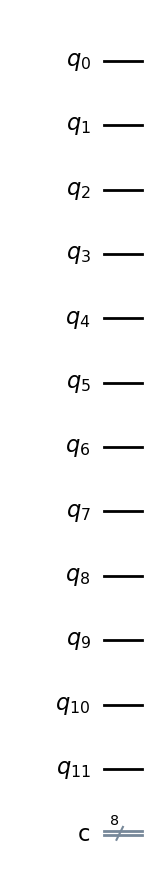

In [21]:
a =7
N = 15
m = 4

qc = QuantumCircuit(a+1 + m, a+1)
qc.draw('mpl')

$q_7,q_6,q_5,q_4,q_3,q_2,q_1,q_0$が第１の量子ビットレジスタ、
$q_{11},q_{10},q_{9},q_8$が第2の量子ビットレジスタに対応します。  

**手順1,2**  
第２の量子ビットレジスタの状態を$|1⟩=|0001⟩$に変換します。つまり$q_{11}$に$X$ゲートを適用します。  
さらに第1量子ビットレジスタにアダマールゲート$H$を適用します。
```
qc.x(11)
for q in range(8):
    qc.h(q)

qc.barrier()
qc.draw('mpl')
```

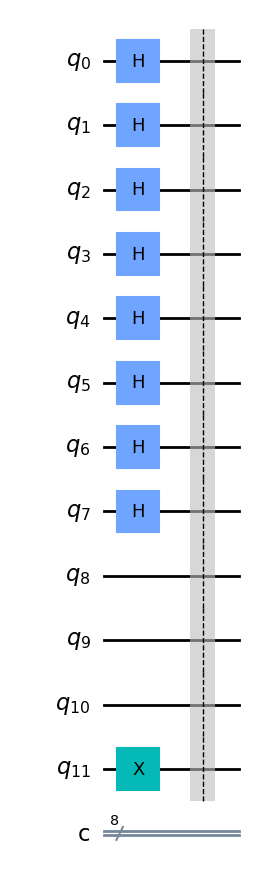

In [22]:
qc.x(11)
for q in range(a+1):
    qc.h(q)

qc.barrier()
qc.draw('mpl')

**手順3**

次に10.2.4節の手順３にある制御$U^{x}$ゲート($CU^x$ゲート)を適用します。
この例の場合、ユニタリー演算 $U$は第2の量子ビットレジスタの状態に以下のように作用します。
$$
U|y\rangle=|7 y \bmod 15\rangle
$$
ここでは、$7 y \bmod 15$の計算に特化した$U$を実装する量子回路を作成しましょう。  

まず、$7 y \bmod 15=(15-8)y \bmod 15=15-8y \bmod 15$であることに注意します。  
$$8y=8(2^3y_1+2^2y_2+2y_3+y_4)=64y_1+32y_2 +16y_3+8y_4$$
ですね。$64 \bmod 15=4, 32 \bmod 15=2, 16 \bmod 15=1, 8 \bmod 15=8$なので、  
$8y \bmod 15=2^2y_1+2y_2+y_3+2^3y_4$となります。  
$15=2^3+2^2+2^1+1$より、結局
$$7 y \bmod 15=15-8y \bmod 15=2^2(1-y_1)+2(1-y_2)+(1-y_3)+2^3(1-y_4)$$
となります。

つまり、$U$はビット列$|y\rangle =|y_1\rangle \otimes |y_2\rangle \otimes |y_3\rangle \otimes |y_4\rangle $
の並びを
$$|y_4\rangle \otimes |y_1\rangle \otimes |y_2\rangle \otimes |y_3\rangle$$
に変え、さらに各ビットを反転(Xゲートを適用)させる作用となります．

よってこの$U$を実行する量子回路は量子ビット状態を交換するスワップゲートと
$X$ゲートによって構成できます。  
そして$U^x$の演算は$U$回路を$x$回繰り返すことで実行されます。

以下のコードにより$CU^x$ゲートを定義します。

```
def c_7mod15(power):# power はU^x のxを意味します。
    U = QuantumCircuit(4)        
    for iteration in range(power):
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
            for q in range(4):
                U.x(q)
    U = U.to_gate() # 回路をひとつのゲートに読み替えます。
    U.name = "7^%i mod 15" % power
    c_U7 = U.control() # 制御ゲートとして定義します。
    return c_U7
```

In [33]:
def c_7mod15(power):# power はU^x のxを意味します。
    U = QuantumCircuit(4)
    for iteration in range(power):
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
            for q in range(4):
                U.x(q)
    U = U.to_gate() # 回路をひとつのゲートに読み替えます。
    U.name = "7^%i mod 15" % power
    c_U7 = U.control() # 制御ゲートとして定義します。
    return c_U7

別の例、$4 y \bmod 15$の計算に特化した$U$を実装する量子回路も作成しておきましょう。(最後の演習問題で使用します。)
$$4y=4(2^3y_1+2^2y_2+2y_3+y_4)=32y_1+16y_2 +8y_3+4y_4$$
ですね。
$32 \bmod 15=2, 16 \bmod 15=1, 8 \bmod 15=8, 4 \bmod 15=4$なので、  
$4y \bmod 15=2y_1+y_2+2^3y_3+2^2y_4$となります。
つまり
$$U|y\rangle =|4y \bmod 15 \rangle =|y_3\rangle \otimes |y_4\rangle \otimes |y_1\rangle \otimes |y_2\rangle$$
です。
この場合の$CU^x$ゲートは以下のコードで定義されます。

```
def c_4mod15(power):# power はU^x のxを意味します。
    U = QuantumCircuit(4)        
    for iteration in range(power):
            U.swap(0,2)
            U.swap(1,3)
    U = U.to_gate() # 回路をひとつのゲートに読み替えます。
    U.name = "4^%i mod 15" % power
    c_U4 = U.control() # 制御ゲートとして定義します。
    return c_U4
```


In [24]:
def c_4mod15(power):# power はU^x のxを意味します。
    U = QuantumCircuit(4)
    for iteration in range(power):
            U.swap(0,2)
            U.swap(1,3)
    U = U.to_gate() # 回路をひとつのゲートに読み替えます。
    U.name = "4^%i mod 15" % power
    c_U4 = U.control() # 制御ゲートとして定義します。
    return c_U4

10.2.4節の手順３の通りに$CU^x$ゲートを適用していきます。
```
for q in range(8):
    qc.append(c_7mod15(2**q),
             [q] + [i+8 for i in range(4)])

qc.barrier()
qc.draw('mpl')
```

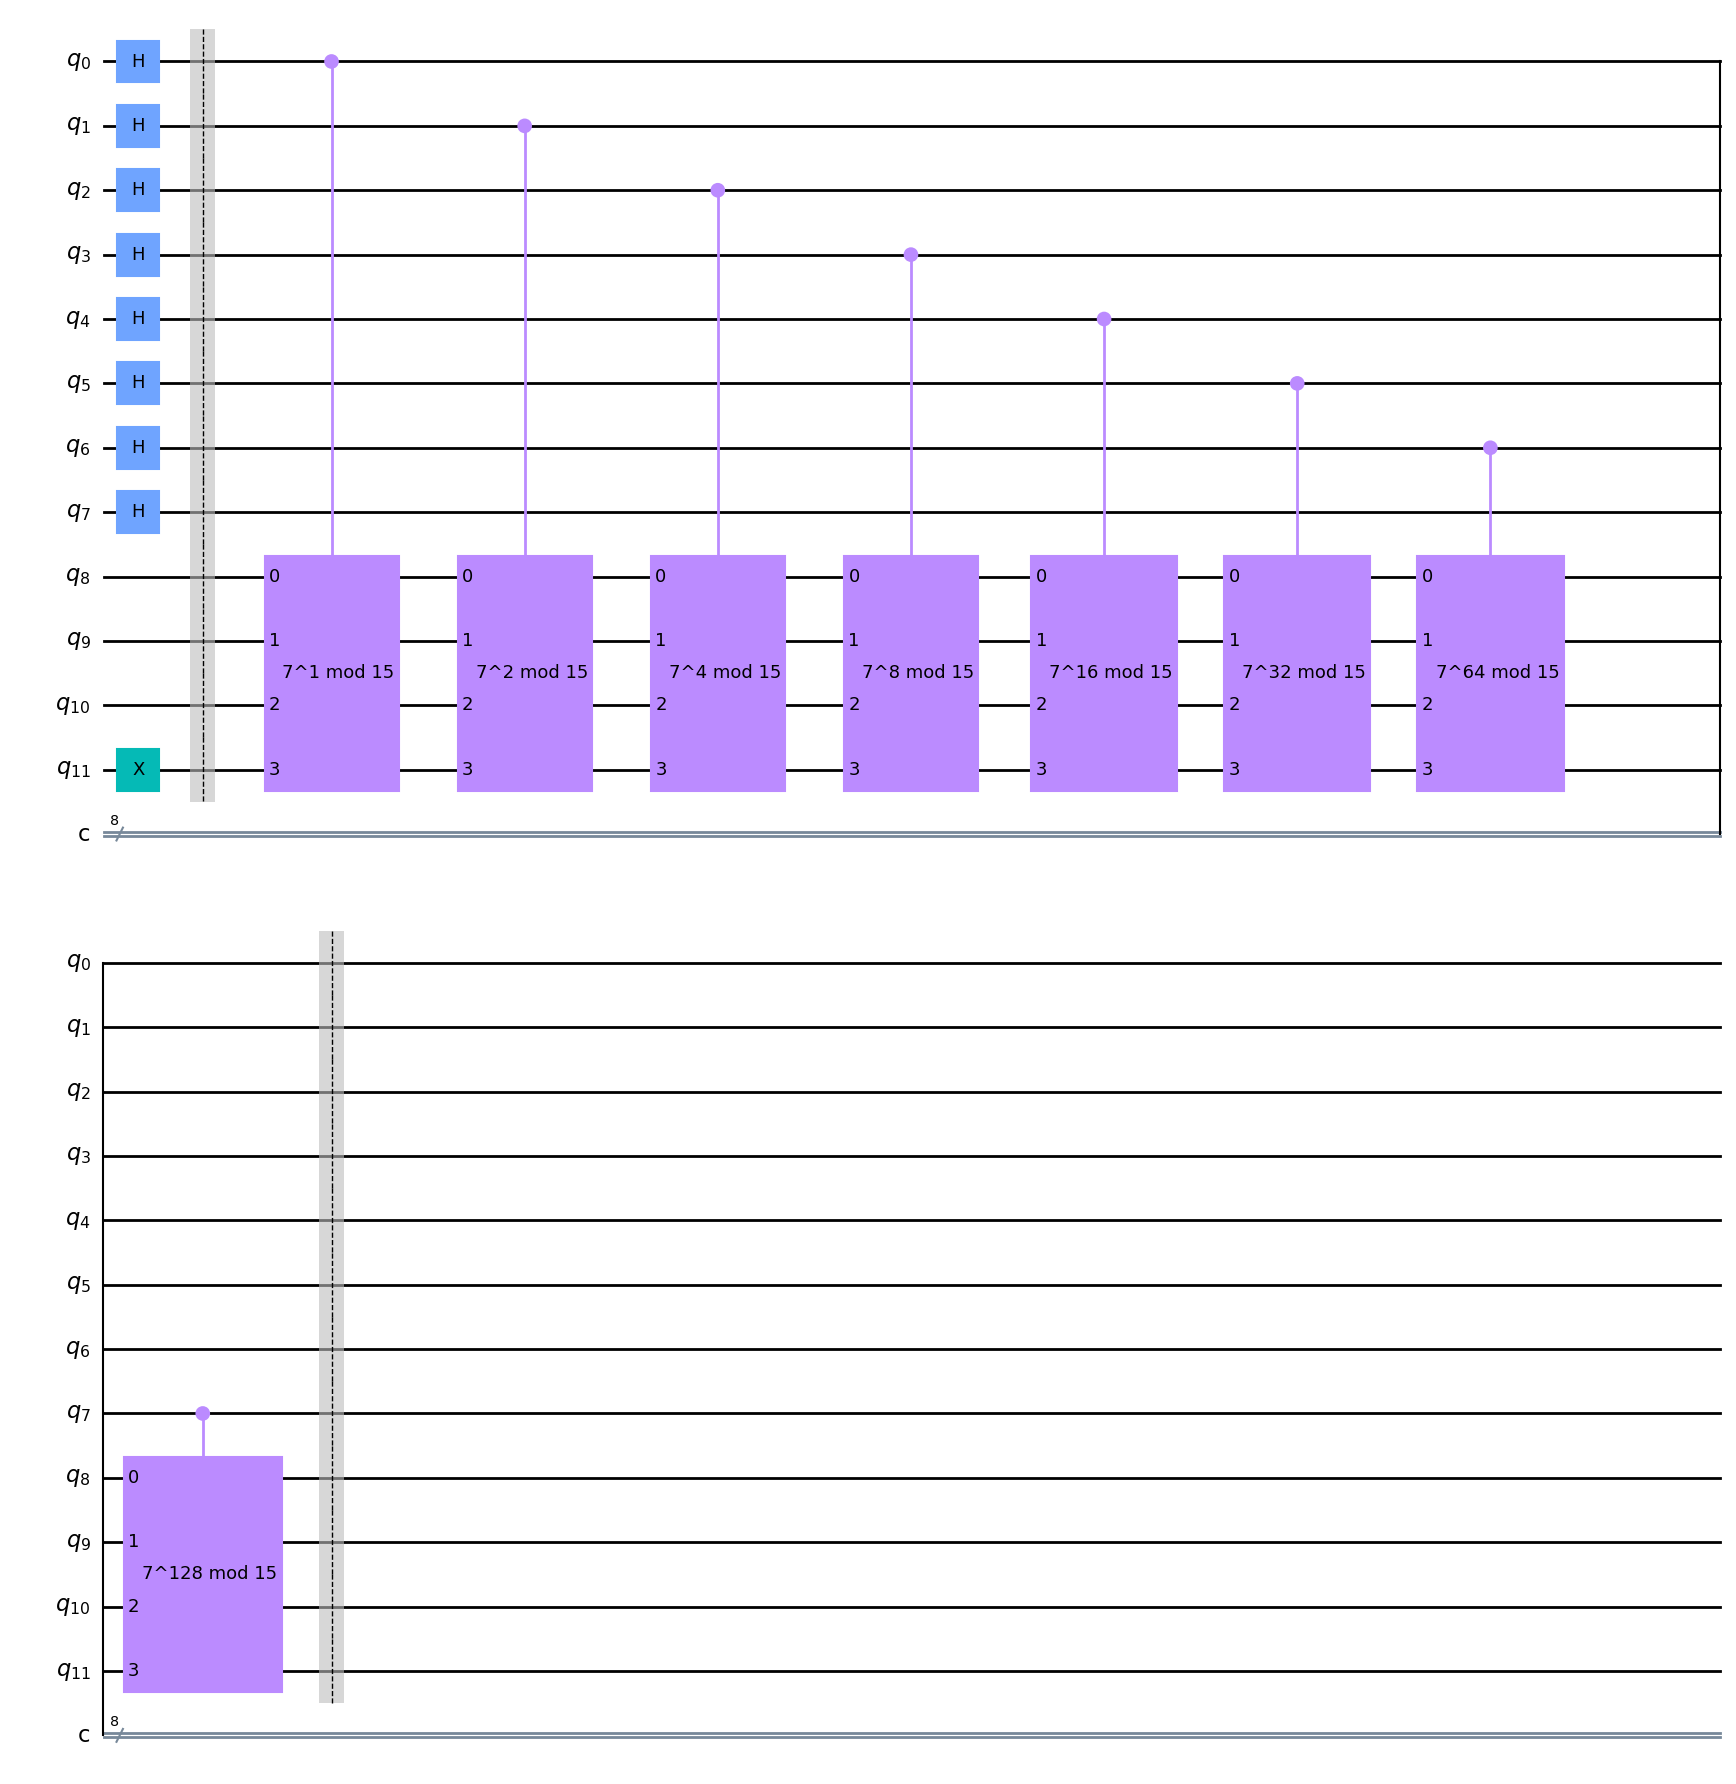

In [25]:
for q in range(8):
    qc.append(c_7mod15(2**q),
             [q] + [i+8 for i in range(4)])

qc.barrier()
qc.draw('mpl')

**手順4**

逆量子フーリエ変換を以下のコードにより適用します。
```
def qft_dagger(n):
    Q = QuantumCircuit(n)
    # Swapsを忘れない!
    for qubit in range(n//2):
        Q.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            Q.cp(-np.pi/float(2**(j-m)), m, j)
        Q.h(j)
    Q.name = "QFT†"
    return Q
```

In [26]:
def qft_dagger(n):
    Q = QuantumCircuit(n)
    # Swapsを忘れない!
    for qubit in range(n//2):
        Q.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            Q.cp(-np.pi/float(2**(j-m)), m, j)
        Q.h(j)
    Q.name = "QFT†"
    return Q

```
qc.append(qft_dagger(8), range(8))
qc.draw('mpl')
```

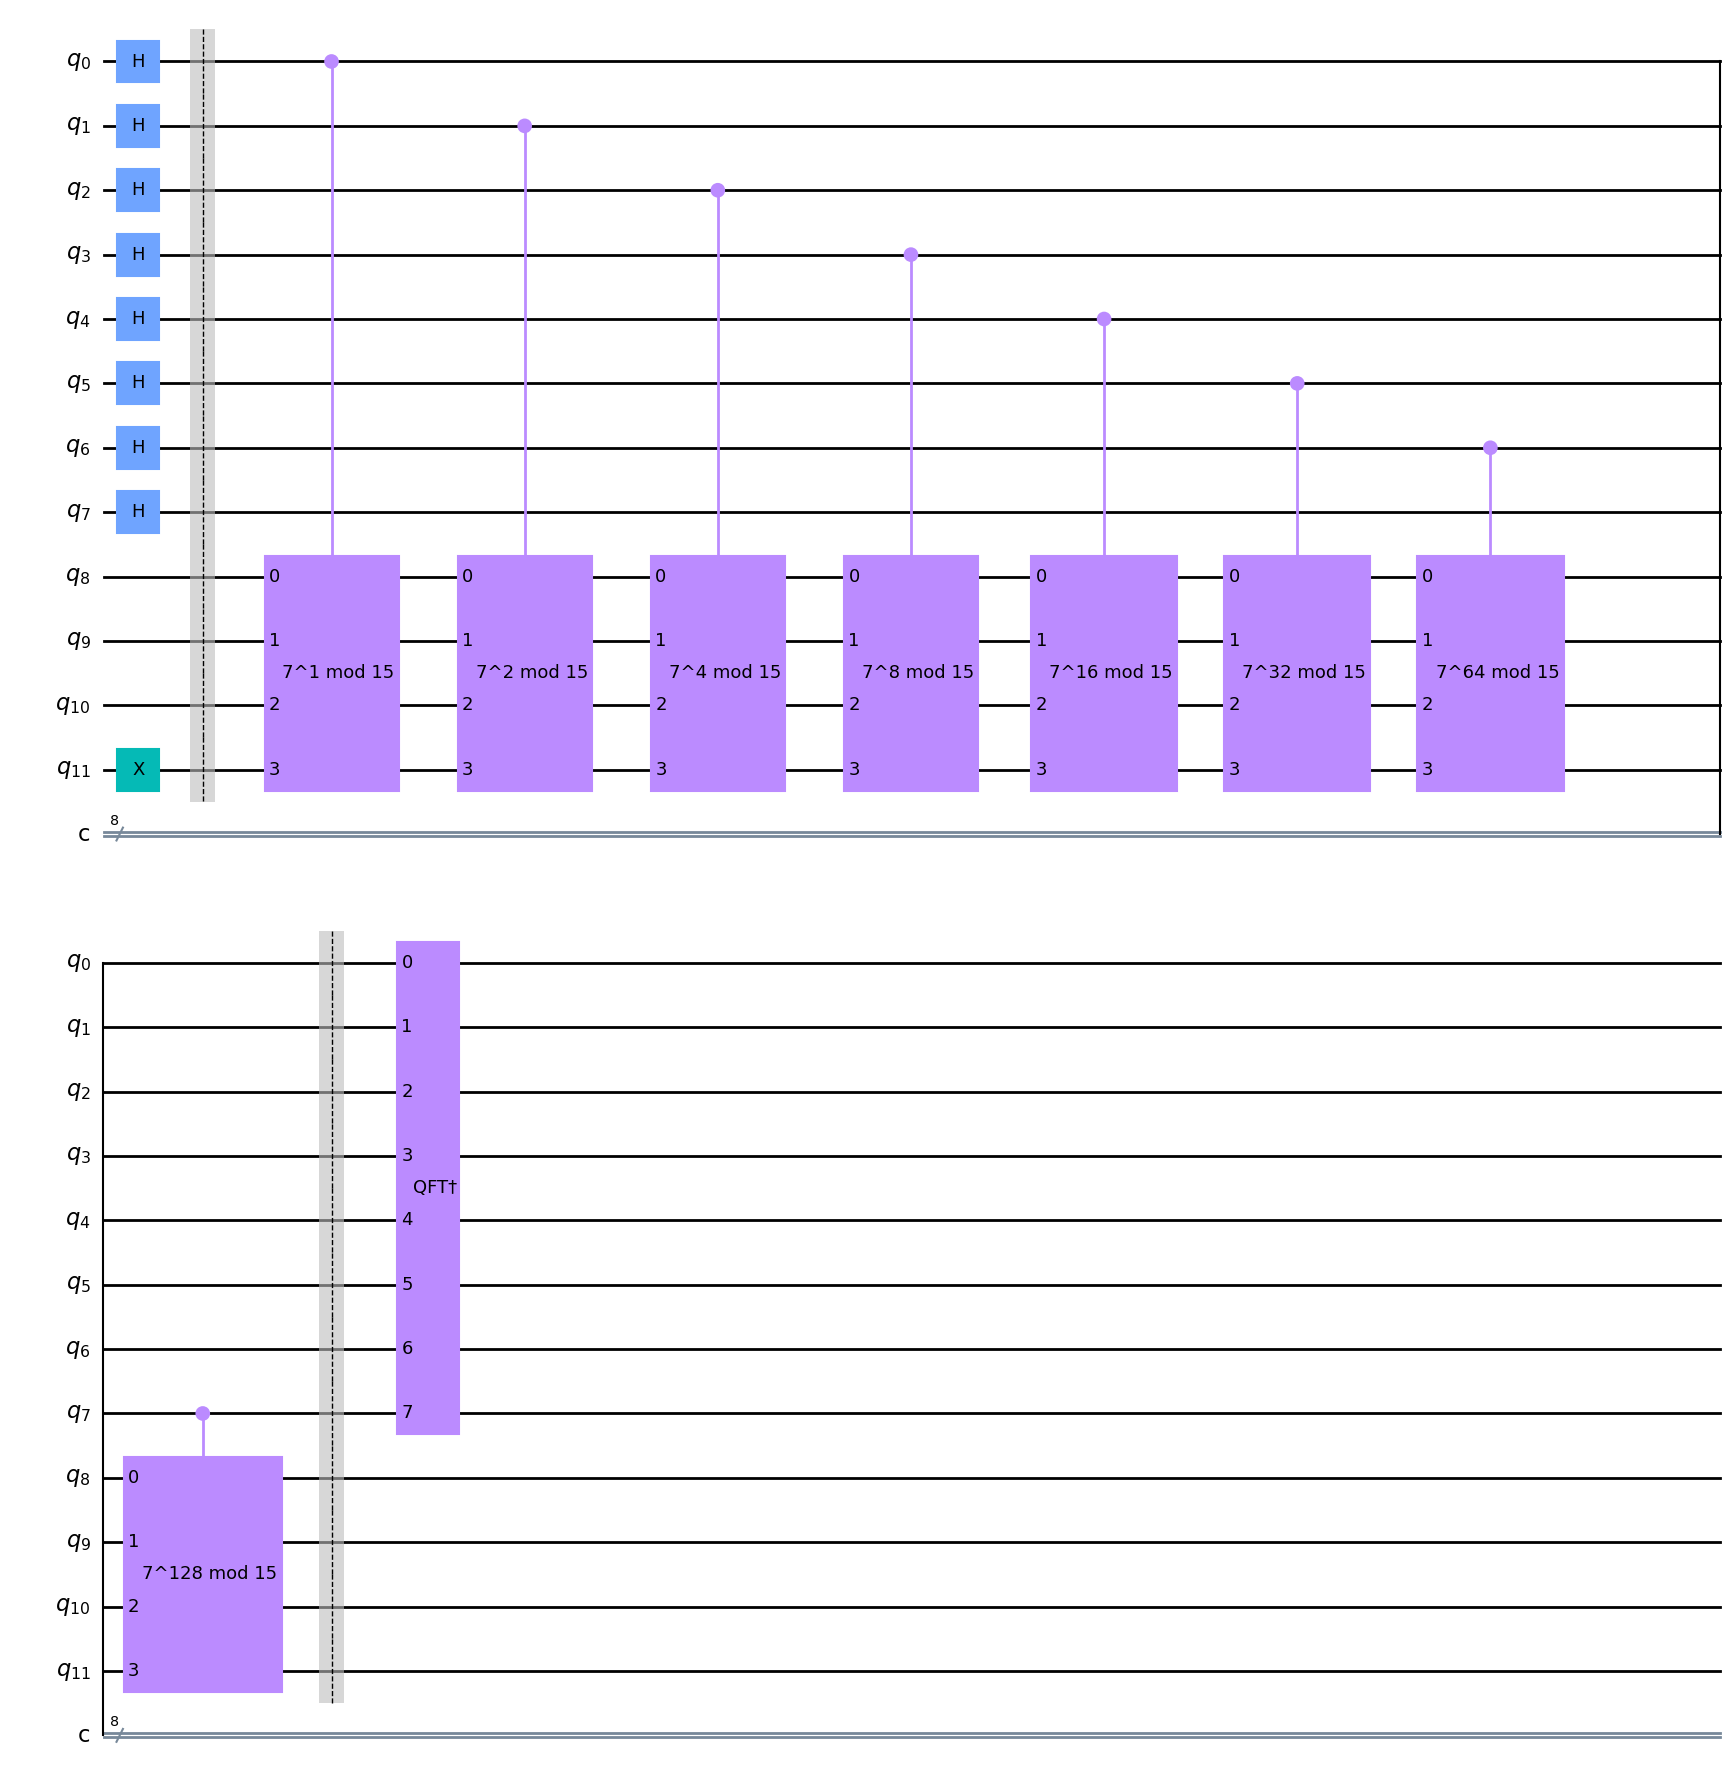

In [27]:
qc.append(qft_dagger(8), range(8))
qc.draw('mpl')

**手順5**

第1量子ビットレジスタに観測を適用します。
```
# 回路を測定
qc.measure(range(8), range(8))
qc.draw('mpl')
```

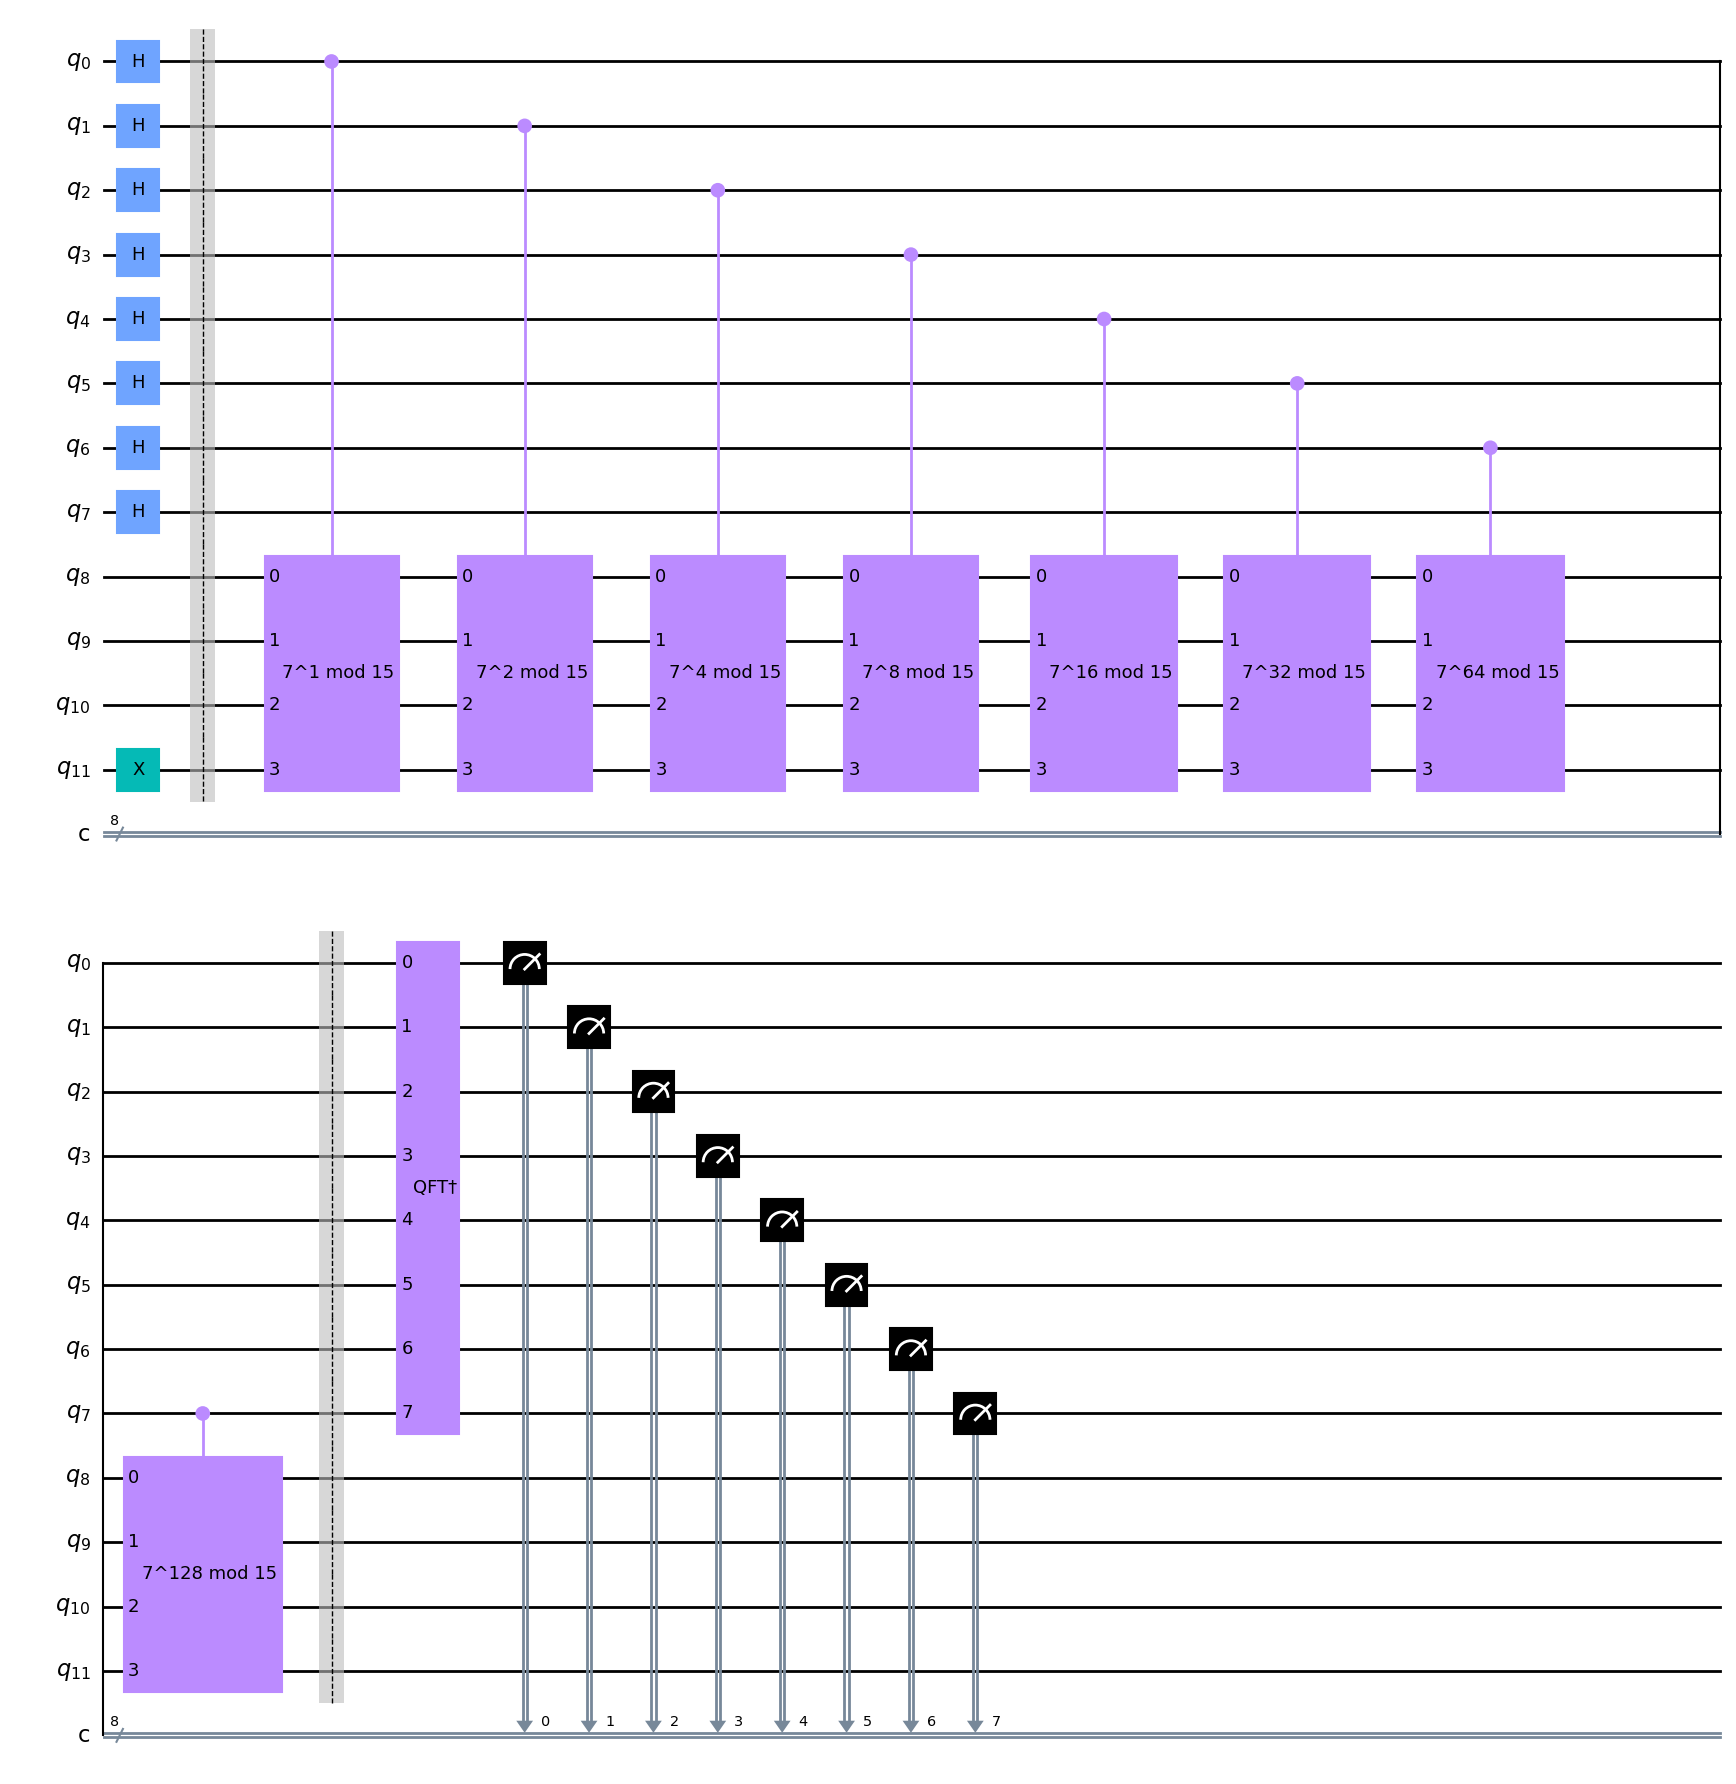

In [28]:
# 回路を測定
qc.measure(range(8), range(8))
qc.draw('mpl')

**シミュレーション**
以下のコードによりシミュレーションをおこなってみましょう。
```
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)
```

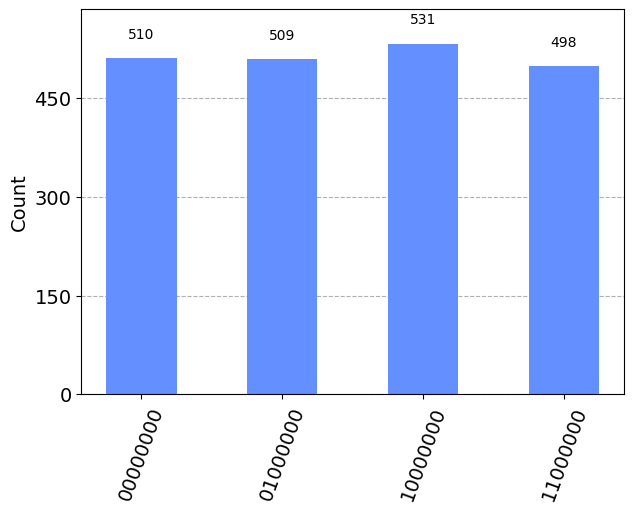

In [29]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

これはアルゴリズムを2048回実行した結果です。  
“00000000”,“01000000”,“10000000”,“11000000”  
のビット列が観測されていますね。  
2進法で計算すると、それぞれ “0”、“64”、“128”、“192”
の値となります。  
これらの値を$2^8=256$で割った値、つまり
$$0, 0.25, 0.5, 0.75$$
が$\frac{s}{r}$の推定値となります。
以下のコードにより、それぞれの値を既約分数化したものを出力します。  
(分母が15未満にするように設定しています。)
```
print(Fraction(0).limit_denominator(15))
print(Fraction(0.5).limit_denominator(15))
print(Fraction(0.75).limit_denominator(15))
print(Fraction(0.25).limit_denominator(15))
```


In [30]:
print(Fraction(0).limit_denominator(15))
print(Fraction(0.5).limit_denominator(15))
print(Fraction(0.75).limit_denominator(15))
print(Fraction(0.25).limit_denominator(15))

0
1/2
3/4
1/4


これにより$7^x\ (\bmod 15)$の周期が$r=4$であることが推定できます。

よって$15$の因数は$7^{2}-1=48$と$15$の最大公約数$3$であることが判明します。

## **演習課題10**

###問題
$4^x\ (\bmod 15)$の周期$r$を発見する量子回路を作成し、周期を推定せよ。

**解答**

量子回路の作成



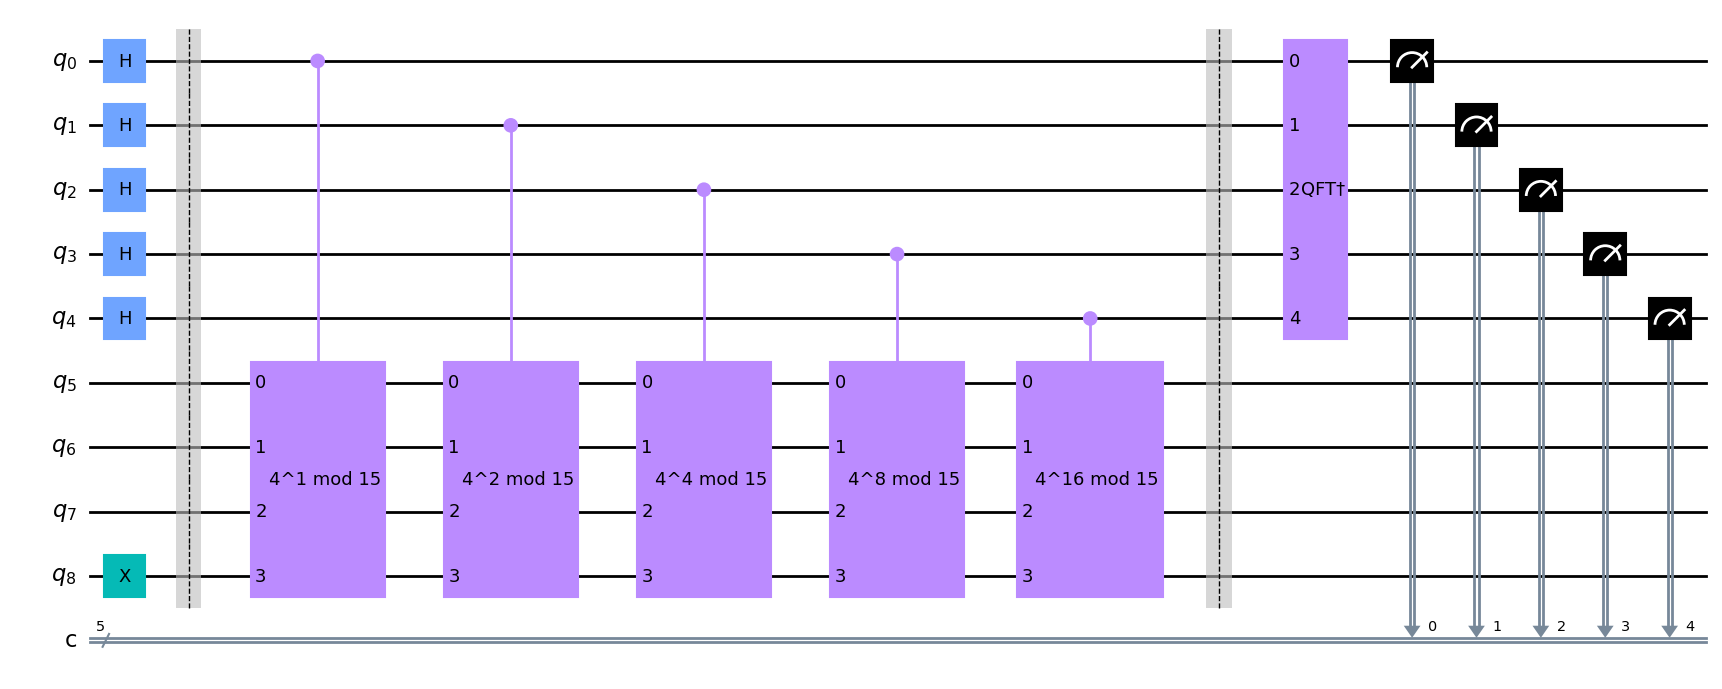

In [35]:
a = 4
N = 15
m = 4

qc = QuantumCircuit(a+1+m, a+1)
qc.draw('mpl')

qc.x(a+m)
for q in range(a+1):
    qc.h(q)

qc.barrier()
qc.draw('mpl')

def c_4mod15(power):# power はU^x のxを意味します。
    U = QuantumCircuit(4)
    for iteration in range(power):
            U.swap(0,2)
            U.swap(1,3)
    U = U.to_gate() # 回路をひとつのゲートに読み替えます。
    U.name = "4^%i mod 15" % power
    c_U4 = U.control() # 制御ゲートとして定義します。
    return c_U4

for q in range(a+1):
    qc.append(c_4mod15(2**q),
             [q] + [i+a+1 for i in range(m)])

qc.barrier()
qc.draw('mpl')


def qft_dagger(n):
    Q = QuantumCircuit(n)
    # Swapsを忘れない!
    for qubit in range(n//2):
        Q.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            Q.cp(-np.pi/float(2**(j-m)), m, j)
        Q.h(j)
    Q.name = "QFT†"
    return Q


qc.append(qft_dagger(a+1), range(a+1))
qc.draw('mpl')

# 回路を測定
qc.measure(range(a+1), range(a+1))
qc.draw('mpl')

シミュレーション

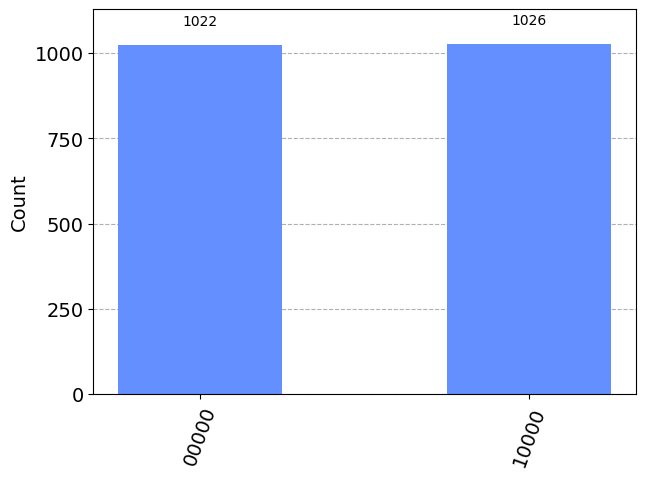

In [36]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

周期は$r=2$と推定されます。